In [0]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

% matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
IMAGE_DIRECTORY = '/content/drive/My Drive/Springboard DS Course/CAPSTONE 2/IMAGES'
REPOSITORY = '/content/drive/My Drive/Springboard DS Course/REPOSITORY/springboard'
os.chdir(REPOSITORY+'/faces_capstone2')

In [34]:
from keras.models import Sequential

class Decoder(Sequential):
  def load_data(self, directory=None):
    self.all_imgs = []
    y_train = []
    y_valid = []
    try:
      for folder in os.listdir(IMAGE_DIRECTORY)[:2]:
        for file in tqdm(os.listdir(IMAGE_DIRECTORY+'/'+folder)[:25]):
          fn = IMAGE_DIRECTORY + '/' + folder + '/' + file
          img = cv2.imread(fn)
          rgb_image =  cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          self.all_imgs.append(rgb_image.astype(np.float32) / 255.)
    except:
      print(file)
    seed = 42
    np.random.seed(seed)
    np.random.shuffle(self.all_imgs)
    #y_train = all_imgs[:40000]
    #y_valid = all_imgs[40000:]
    #x_valid = np.arange(len(y_valid))
    x_all = np.arange(len(self.all_imgs))
    self.all_dim = np.asarray(self.all_imgs).shape[0]
    TRAIN_DIM = np.asarray(y_train).shape[0]
    VALID_DIM = np.asarray(y_valid).shape[0]
    self.x = np.array(x_all)
    self.y = np.array(self.all_imgs)
  def build_model(self, n_components, model_filename, log_filename, decoder=None):
    decoder = Sequential()
    decoder.add(Embedding(input_dim=self.all_dim, output_dim=n_components, input_length=1))
    decoder.add(Flatten())
    decoder.add(Reshape((1, 1, n_components)))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=1, activation='relu'))
    decoder.add(Conv2DTranspose(filters=32, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=16, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=8, kernel_size=3, strides=2, activation='relu'))
    decoder.add(Conv2DTranspose(filters=3, kernel_size=4, strides=2, activation='sigmoid'))
    decoder.compile(optimizer='adam', loss='mse')
    self.model_filename = model_filename
    decoder.save(self.model_filename)
    self.decoder = decoder
    data_dict = {'Date':[datetime.now()], 'Run_Number':[0], 'Num_Epochs_Tot':[0]}
    train_log = pd.DataFrame.from_dict(data_dict)
    self.log_filename = log_filename
    train_log.to_csv(self.log_filename)
  def fit_model(self, i, batch_size, n_epochs):
    model = load_model(self.model_filename)
    model.fit(self.x, self.y, batch_size=batch_size, epochs=n_epochs, validation_split=0.2)
    model.save(self.model_filename)
    train_log = pd.read_csv(self.log_filename)
    data_dict = {'Date':[datetime.now()], 'Run_Number':[i+1], 'Num_Epochs_Tot':[N_EPOCHS*(i+1)]}
    train_log = train_log.append(data_dict, ignore_index=True)
    train_log.to_csv(self.log_filename)
  def predict_model(self, batch_size):
    self.decoder = load_model(self.model_filename)
    return self.decoder.predict(self.x, batch_size=batch_size)

Using TensorFlow backend.


In [0]:
def save_to_git(commit_msg):
  os.chdir(REPOSITORY)
  %evMSG=commit_msg
  !git pull
  !git add .
  !git commit -m $MSG
  !git push

In [41]:
decoder_model = Decoder()
decoder_model.load_data()

100%|██████████| 25/25 [00:14<00:00,  1.89it/s]


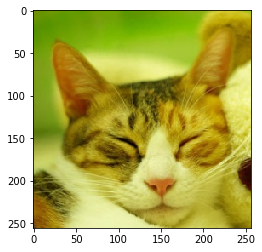

50


In [42]:
plt.imshow(decoder_model.all_imgs[42])
plt.show()
print(len(decoder_model.all_imgs))

In [43]:
#from keras.models import Sequential
from keras.layers import Activation, Input, Flatten, Reshape
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras import backend as K
K.set_image_data_format('channels_last')
K.clear_session()

In [44]:
BATCH_SIZE = 10
N_COMPONENTS = 100
MODEL_FN = 'decoder.h5'
LOGS_FN = 'train_log.csv'
N_EPOCHS = 5

decoder_model.build_model(N_COMPONENTS, MODEL_FN, LOGS_FN)

In [45]:
from keras.models import load_model

for i in range(2):
  print('Training Batch # %d' % (i+1))
  decoder_model.fit_model(i, BATCH_SIZE, N_EPOCHS)
  print('Trained %d epochs for total of %d epochs total' % (N_EPOCHS, N_EPOCHS*(i+1)))


Training Batch # 1


Train on 40 samples, validate on 10 samples
Epoch 1/5
40/40 [==============================] - 7s 165ms/step - loss: 0.0739 - val_loss: 0.0792
Epoch 2/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0737 - val_loss: 0.0790
Epoch 3/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0735 - val_loss: 0.0787
Epoch 4/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0733 - val_loss: 0.0784
Epoch 5/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0729 - val_loss: 0.0780
Trained 5 epochs for total of 5 epochs total
Training Batch # 2
Train on 40 samples, validate on 10 samples
Epoch 1/5
40/40 [==============================] - 0s 11ms/step - loss: 0.0726 - val_loss: 0.0775
Epoch 2/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0721 - val_loss: 0.0769
Epoch 3/5
40/40 [==============================] - 0s 1ms/step - loss: 0.0714 - val_loss: 0.0760
Epoch 4/5
40/40 [==============================]

In [0]:
compressed = decoder_model.predict_model(batch_size=BATCH_SIZE)

11


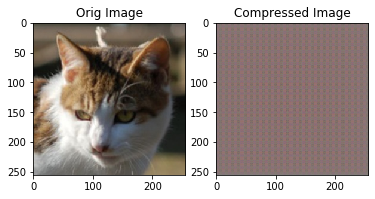

In [48]:
PIC = np.random.choice(50)
print(PIC)
plt.subplot(1,2,1)
plt.imshow(decoder_model.all_imgs[PIC])
plt.title('Orig Image')

plt.subplot(1,2,2)
plt.imshow(compressed[PIC])
plt.title('Compressed Image')

plt.show()

In [7]:
save_to_git('refactored code')

Already up to date.
error: switch `m' requires a value
usage: git commit [<options>] [--] <pathspec>...

    -q, --quiet           suppress summary after successful commit
    -v, --verbose         show diff in commit message template

Commit message options
    -F, --file <file>     read message from file
    --author <author>     override author for commit
    --date <date>         override date for commit
    -m, --message <message>
                          commit message
    -c, --reedit-message <commit>
                          reuse and edit message from specified commit
    -C, --reuse-message <commit>
                          reuse message from specified commit
    --fixup <commit>      use autosquash formatted message to fixup specified commit
    --squash <commit>     use autosquash formatted message to squash specified commit
    --reset-author        the commit is authored by me now (used with -C/-c/--amend)
    -s, --signoff         add Signed-off-by:
    -t, --template

In [0]:
print(decoder_model.summary())

ValueError: ignored